In [1]:
from typing import List, Tuple, Dict, Union
import os

import tqdm
from pprint import pprint

import json
import numpy as np
import pandas as pd

from datasets import Dataset

import re

# Uncomment to download stopwords and wordnet
#   import nltk
#   nltk.download('stopwords')
#   nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import gensim
from gensim.utils import simple_preprocess

from top2vec import Top2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import spacy
from spacy.matcher import Matcher
from spacy import displacy

from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset

from scipy.special import softmax
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


class G:
    """Helper class to store global variables"""
    
    from pathlib import Path
    
    proj_dir = Path.cwd().parent
    mdls_dir = proj_dir / "models"
    data_dir = proj_dir / "data"
    ext_path = data_dir / "extracts" / "item1a-full-scored-sents.json"
    t2v_path = mdls_dir / "top2vec" / "doc2vec-deep-learn-16-topics.pkl"
    
    lemmatizer = WordNetLemmatizer()
    stopwords  = set(stopwords.words("english")) | \
                    {"may", "could", "result", "mine", "coal", "finance", 
                        "price", "risk", "u", "company", "result", 
                        "financial", "mineral", "adverse", "adversely", 
                        "affect", "effect", "include"}
    
    t2v  = Top2Vec.load(t2v_path)
    nlp  = spacy.load("en_core_web_sm")
    pipe = pipeline("sentiment-analysis", model="ProsusAI/finbert", device=0)

    passive_rules = [{"DEP": "nsubjpass"},
                     {"DEP": "aux", "OP": "*"},
                     {"DEP": "auxpass"},
                     {"TAG": "VBN"}]
    passive_matcher = Matcher(nlp.vocab)
    passive_matcher.add("is_passive", [passive_rules])

    @classmethod
    def load_data(cls):
        """Load sentences from the extracted json file."""

        with open(cls.ext_path) as f:
            cls.ext_data = json.load(f)
    
    @classmethod
    def lemmatize_single(cls, token: str) -> str:
        """Lemmatize the given token. Try all possible 
            lemmatization (n, v, a, r, s) until the input changes."""
            
        all_pos = ["n", "v", "a", "r", "s"]

        ret = token
        while (ret == token) and all_pos:
            ret = G.lemmatizer.lemmatize(token, all_pos.pop(0))
        return ret

    @classmethod
    def keep_token(cls, token: str) -> bool:
        """Check if the given token is a valid word."""
        
        return token not in G.stopwords

    @classmethod
    def gensim_tokenize_single(cls, text: str, is_lemma: bool = True) -> List[str]:
        """Tokenize the given text using gensim's 
            simple_preprocess. Punctuations and stopwords
            are removed, and the tokens are lemmatized."""
        
        fn_lemma = cls.lemmatize_single if is_lemma else lambda x: x
        ret = [fn_lemma(t) for t in simple_preprocess(text, min_len=3)]
        return [t for t in ret if cls.keep_token(t)]
    
    @classmethod
    def make_predictor(cls, vectorizer: TfidfVectorizer, table):
        """Given a tf-idf vectorizer and a tf-idf table, 
            construct a cluster attributor that predict the
            cluster belonging of a given text."""
        
        def predictor(s: Union[str, List[str]], 
                      return_scores: bool = False,
                      threshold: float = 0.1) -> np.ndarray:
            
            if isinstance(s, str):
                s = [s]
            
            v = vectorizer.transform(s)
            s = cosine_similarity(v, table)

            if return_scores:
                return s
            
            if threshold is not None:
                ret = []
                for c in s:
                    if c.max() > threshold:
                        ret.append(np.where(c > threshold)[0].tolist())
                    else:
                        ret.append([c.argmax()])
                return ret
            
            return s.argmax(axis=1)

        return predictor
    
    @classmethod
    def paragraphs2sentences(cls, texts: List[str]) -> List[List[str]]:
        """Split paragraphs into sentences."""
        
        ret = [[sent.text for sent in doc.sents] 
                    for doc in cls.nlp.pipe(texts, batch_size=128)]
        return ret
    
    @staticmethod
    def flatten_nested_list(nested_list: List[List]) -> List:
        """Flatten a nested list."""
        
        return [item for sublist in nested_list for item in sublist]
    
    @staticmethod
    def list2key_dataset(l: List[str], key: str = "text") -> KeyDataset:
        """Convert a list to a KeyDataset."""

        return KeyDataset(Dataset.from_dict({key: l}), key)

    @classmethod
    def is_active_voice_spacy(cls, doc: spacy.tokens.Doc) -> bool:
        """Given a sentence (`Doc`), check if the sentence is in NOT in passive voice."""

        matches = cls.passive_matcher(doc)
        # for match_id, start, end in matches:
        #     print(doc[start:end].text)
        return len(matches) == 0
    
    @classmethod
    def is_potential_action(cls, batch: List[str]) -> List[bool]:
        """Try to filter out action related sentences via financial sentiment analysis
            The basic assumption is that sentences describing actions are more likely 
            to be positive than those describing risks they are facing.
            
            1. The subject of the sentence need to be the company (or a pronoun)
            2. Check if a sentence is more positive than negative."""

        def subj_is_pron_or_propn(doc: spacy.tokens.Doc) -> bool:
            """Check if the subject of the given sentence is either 
                proper noun (e.g., company names) or pronoun (e.g. `we`)"""
            
            for token in doc:
                if token.dep_ == "nsubj" and token.head.pos_ in {"VERB", "AUX"}:
                    if (token.pos_ == "PRON" and token.text.lower() == "we") \
                        or (token.pos_ == "PROPN" and token.ent_type_ in {"ORG", "PRODUCT"}): 
                        return True
                    
                    # E.g., OUR goal
                    if token.pos_ == "NOUN":
                        for child in token.children:
                            if child.dep_ == "poss" and child.text.lower() == "our":
                                return True
            return False

        def comp_pos_neg(pred: List[Dict]) -> bool:
            """Compare the positive and negative scores."""
            
            pos = neg = 0
            for p in pred:
                if p["label"] == "positive":
                    pos = p["score"]
                if p["label"] == "negative":
                    neg = p["score"]
            return pos > neg and pos > 0.2
        
        docs = cls.nlp.pipe(batch)
        predictions = cls.pipe(cls.list2key_dataset(batch), 
                               batch_size=256, 
                               top_k=3,
                               max_length=64,
                               truncation=True)
        return [comp_pos_neg(p) and cls.is_active_voice_spacy(d) 
                    for d, p in zip(docs, predictions)]

In [2]:
G.load_data()

In [3]:
G.is_potential_action(["Potential investors should be aware of the difficulties normally encountered by new mineral exploration companies such Oroplata and the high rate of failure of companies such as ours.", 
                       "We may also become subject to significant liability for pollution, cave-ins or hazards, which we cannot insure or which we may elect not to insure.",
                       "In such a case, we would be unable to complete our business plan and our future shareholders may lose their entire investment.",
                       "We believe our operations can provide valuable benefits to surrounding communities, in terms of direct employment, training and skills development and other benefits associated with ongoing payment of taxes.",
                       "During the past several years Solitario has conducted an active social engagement program with the community located near the La Promesa project area with the objective of obtaining a community agreement to support exploration activities, including drilling.",
                       "From time to time Nexa may enter into surface rights agreements with individual landowners or communities to provide access for exploration work at the Florida Canyon project. Generally, these are short-term agreements.",
                       "During 2020 our objectives are to complete an agreement with the local community, to conduct surface exploration, and if warranted, conduct a drilling program.",
                       "In addition, we seek to maintain our partnerships and relationships with local communities, including indigenous peoples, and stakeholders in a variety of ways, including in-kind contributions, volunteer time, sponsorships and donations.",
                       "We have adopted certain policies and programs, including with respect to responsible production frameworks, climate change, water stewardship, biodiversity, tailings management and stewardship, waste management, safety and health, human capital management, human rights, social performance and community and Indigenous Peoples relations, and supply chain/responsible sourcing.",
                       "We have received, and may continue to receive, a high degree of media coverage that is published or otherwise disseminated by third parties, including blogs, articles, online forums, message boards and social and other media.",
                       "Newmont has implemented a management system designed to promote continuous improvement in health and safety, environmental performance and community relations.",
                       "Our ability to obtain the required permits and approvals to explore for, develop and operate mines and to successfully operate near communities in the jurisdictions in which we operate depends in part on our ability to develop, operate and close mines in a manner that is consistent with the creation of social and economic benefits in the surrounding communities, which may or may not be required by law.",
                       "We participated also in a working group with the local and regional authorities and communities to define Company support for their social and community programs.",
                       "During 2012, we started negotiations with all the eight unions."])

[False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True]

## __Evaluate the Performance of Passive-active Voice Classifier with CoLA__

Accuracy: 0.9651324965132496
F1: 0.8062015503875969


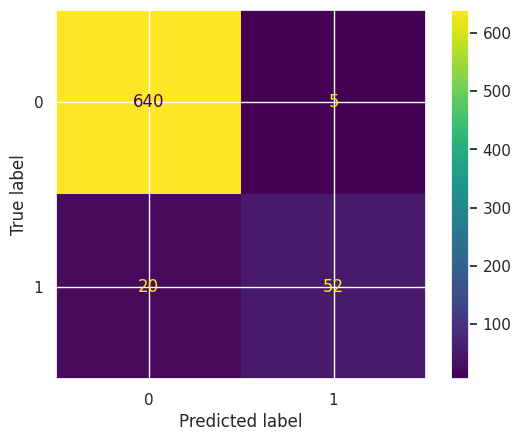

In [4]:
df_cola = pd.read_csv("../data/cola/minor.tsv", sep="\t")
df_cola = df_cola.loc[df_cola.Acceptability == 1, ["Sentence", "Passive"]]
df_cola.loc[:, "PredictedPassive"] = [int(not G.is_active_voice_spacy(d)) for d in G.nlp.pipe(df_cola.Sentence)]
print("Accuracy:", accuracy_score(df_cola.Passive, df_cola.PredictedPassive))
print("F1:", f1_score(df_cola.Passive, df_cola.PredictedPassive))
ConfusionMatrixDisplay.from_predictions(df_cola.Passive, df_cola.PredictedPassive)

In [5]:
df_cola.loc[df_cola["PredictedPassive"] != df_cola["Passive"]]

,Sentence,Passive,PredictedPassive
208,Soaring temperatures are predicted for this we...,0,1
322,Each candidate who has interest in semantics w...,1,0
374,It seems that Lucy was mugged.,0,1
391,"Any tiger has orange fur, marked with black st...",1,0
396,The Dodgers beat the Red Sox and were beaten b...,1,0
397,In which car was the man seen?,1,0
424,Emma and Harriet were attacked yesterday.,1,0
563,His or her least known work.,1,0
582,"Meg is attracted to Harry, but they don't know...",0,1
607,She's been dancing but we don't know with whom.,0,1


In [6]:
# displacy.render(G.nlp("During 2020 our objectives are to complete an agreement with the local community, to conduct surface exploration, and if warranted, conduct a drilling program."), 
#                 style="dep", jupyter=True)

In [7]:
# Collect topic keywords for each reduced topic
tfidf_vec = TfidfVectorizer(tokenizer=G.gensim_tokenize_single)
tfidf_tbl = tfidf_vec.fit_transform([" ".join(t) for t in G.t2v.topic_words_reduced.tolist()])
tfidf_prd = G.make_predictor(tfidf_vec, tfidf_tbl)

In [9]:
for document in tqdm.tqdm(G.ext_data):
    document["item1a_sentences_flatten"] = G.flatten_nested_list(document["item1a_sentences"])
    document["is_action"] = G.is_potential_action(document["item1a_sentences_flatten"])
    document["topic_ids"] = tfidf_prd(document["item1a_sentences_flatten"])

  2%|▏         | 7/367 [00:02<01:19,  4.55it/s]/home/dogdog/Miniconda3/envs/wharton/lib/python3.9/site-packages/transformers/pipelines/base.py:1036: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 367/367 [11:44<00:00,  1.92s/it]


In [48]:
df = []
for document in G.ext_data:
    for i, (s, is_action, topic_ids) in enumerate(zip(document["item1a_sentences_flatten"], 
                                                      document["is_action"], 
                                                      document["topic_ids"])):
        df.append({
            "symbol": document["symbol"],
            "filing_time": document["filing_time"],
            "sentence": s,
            "is_action": is_action,
            "topic_ids": topic_ids,
        })
df = pd.DataFrame(df)

df["is_active"] = [G.is_active_voice_spacy(d) for d in G.nlp.pipe(df.sentence)]
df.head()

,symbol,filing_time,sentence,is_action,topic_ids,is_active
0,abml,2013-12,The Risk Factors below are provided for a pote...,False,[3],True
1,abml,2013-12,There is a high degree of risk in the purchase...,False,"[3, 6]",True
2,abml,2013-12,"If any of the following risk materialize, it c...",False,[9],True
3,abml,2013-12,A potential investor must be aware that he or ...,False,[1],True
4,abml,2013-12,Risks Factors Which May Effect Our Business Be...,False,"[1, 8]",True


In [49]:
df.sample(frac=0.1).reset_index(drop=True).to_csv(G.data_dir / "statistics" / "action-sentences-sample.csv", index=False)

In [50]:
# Filtered by topic
df.loc[df.topic_ids.apply(lambda x: len(set(x).intersection({2, 13, 14})) > 0)].sample(frac=0.1).reset_index(drop=True).to_csv(G.data_dir / "statistics" / "action-sentences-topic-filtered-sample.csv", index=False)

In [20]:
# Get total number of sentences for each firm-year level
df_tot_cnt = df.groupby(["symbol", "filing_time"]).size().reset_index(name="total_risk_sentence_count")
df_tot_cnt.head()

,symbol,filing_time,total_risk_sentence_count
0,abml,2013-12,135
1,abml,2015-01,111
2,abml,2015-12,1
3,abml,2016-12,1
4,abml,2018-01,1


In [47]:
# Explode the topic_ids column and count the number of sentences for each topic
df_topic_dist = df.explode("topic_ids") \
                  .groupby(["symbol", "filing_time"])["topic_ids"] \
                  .value_counts(normalize=False) \
                  .unstack(fill_value=0) \
                  .add_prefix("topic_reduced_") \
                  .reset_index() \
                  .rename_axis(None, axis=1) \
                  .merge(df_tot_cnt, on=["symbol", "filing_time"])
df_topic_dist.head()

,symbol,filing_time,topic_reduced_0,topic_reduced_1,topic_reduced_2,topic_reduced_3,topic_reduced_4,topic_reduced_5,topic_reduced_6,topic_reduced_7,topic_reduced_8,topic_reduced_9,topic_reduced_10,topic_reduced_11,topic_reduced_12,topic_reduced_13,topic_reduced_14,topic_reduced_15,total_risk_sentence_count
0,abml,2013-12,2,54,5,27,3,8,26,19,25,13,2,9,5,0,6,7,135
1,abml,2015-01,1,44,5,26,3,6,24,14,22,12,2,9,1,0,3,7,111
2,abml,2015-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,abml,2016-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,abml,2018-01,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [51]:
# Do the same statistics for active sentences
df_tot_cnt_active = df.loc[df.is_active, ["symbol", "filing_time"]] \
                      .groupby(["symbol", "filing_time"]) \
                      .size() \
                      .reset_index(name="total_active_sentence_count")
df_tot_cnt_active.head()

,symbol,filing_time,total_active_sentence_count
0,abml,2013-12,116
1,abml,2015-01,96
2,abml,2015-12,1
3,abml,2016-12,1
4,abml,2018-01,1


In [52]:
df_topic_dist_active = df.loc[df.is_active, :] \
                            .explode("topic_ids") \
                            .groupby(["symbol", "filing_time"])["topic_ids"] \
                            .value_counts(normalize=False) \
                            .unstack(fill_value=0) \
                            .add_prefix("topic_reduced_active_") \
                            .reset_index() \
                            .rename_axis(None, axis=1) \
                            .merge(df_tot_cnt_active, on=["symbol", "filing_time"])
df_topic_dist_active.head()

,symbol,filing_time,topic_reduced_active_0,topic_reduced_active_1,topic_reduced_active_2,topic_reduced_active_3,topic_reduced_active_4,topic_reduced_active_5,topic_reduced_active_6,topic_reduced_active_7,topic_reduced_active_8,topic_reduced_active_9,topic_reduced_active_10,topic_reduced_active_11,topic_reduced_active_12,topic_reduced_active_13,topic_reduced_active_14,topic_reduced_active_15,total_active_sentence_count
0,abml,2013-12,2,48,4,24,3,5,23,14,22,12,1,6,4,0,6,6,116
1,abml,2015-01,1,40,3,23,3,4,21,11,19,11,1,6,1,0,3,6,96
2,abml,2015-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,abml,2016-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,abml,2018-01,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [53]:
# Do the same statistics for action sentences
df_tot_cnt_action = df.loc[df.is_action, ["symbol", "filing_time"]] \
                        .groupby(["symbol", "filing_time"]) \
                        .size() \
                        .reset_index(name="total_action_sentence_count")
df_tot_cnt_action.head()

,symbol,filing_time,total_action_sentence_count
0,abml,2013-12,15
1,abml,2015-01,12
2,amr,2019-04,41
3,amr,2020-03,40
4,amr,2021-03,41


In [54]:
df_topic_dist_action = df.loc[df.is_action, :] \
                            .explode("topic_ids") \
                            .groupby(["symbol", "filing_time"])["topic_ids"] \
                            .value_counts(normalize=False) \
                            .unstack(fill_value=0) \
                            .add_prefix("topic_reduced_action_") \
                            .reset_index() \
                            .rename_axis(None, axis=1) \
                            .merge(df_tot_cnt_action, on=["symbol", "filing_time"])
df_topic_dist_action.head()

,symbol,filing_time,topic_reduced_action_0,topic_reduced_action_1,topic_reduced_action_2,topic_reduced_action_3,topic_reduced_action_4,topic_reduced_action_5,topic_reduced_action_6,topic_reduced_action_7,topic_reduced_action_8,topic_reduced_action_9,topic_reduced_action_10,topic_reduced_action_11,topic_reduced_action_12,topic_reduced_action_13,topic_reduced_action_14,topic_reduced_action_15,total_action_sentence_count
0,abml,2013-12,0,10,0,0,0,0,0,6,6,0,0,0,0,0,1,0,15
1,abml,2015-01,0,7,0,0,0,1,0,6,5,0,0,0,0,0,0,0,12
2,amr,2019-04,5,5,6,5,10,4,2,2,6,2,0,1,15,1,12,2,41
3,amr,2020-03,7,5,6,4,9,2,6,2,3,1,0,2,12,0,10,1,40
4,amr,2021-03,7,5,7,3,9,2,4,2,5,1,0,2,17,0,10,1,41


In [64]:
# Merge the three statistics together
df_final = df_topic_dist.merge(df_topic_dist_active, on=["symbol", "filing_time"], how="left") \
                        .merge(df_topic_dist_action, on=["symbol", "filing_time"], how="left") \
                        .fillna(0)

# Set all numerical columns to integer
df_final = df_final.astype({c: int for c in df_final.columns if c not in ["symbol", "filing_time"]})
df_final.head()

,symbol,filing_time,topic_reduced_0,topic_reduced_1,topic_reduced_2,topic_reduced_3,topic_reduced_4,topic_reduced_5,topic_reduced_6,topic_reduced_7,...,topic_reduced_action_7,topic_reduced_action_8,topic_reduced_action_9,topic_reduced_action_10,topic_reduced_action_11,topic_reduced_action_12,topic_reduced_action_13,topic_reduced_action_14,topic_reduced_action_15,total_action_sentence_count
0,abml,2013-12,2,54,5,27,3,8,26,19,...,6,6,0,0,0,0,0,1,0,15
1,abml,2015-01,1,44,5,26,3,6,24,14,...,6,5,0,0,0,0,0,0,0,12
2,abml,2015-12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,abml,2016-12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,abml,2018-01,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
df_final.to_csv(G.data_dir / "statistics" / "sentences-topic-distribution.csv", index=False)